Load dependencies

In [3]:
import scanpy as sc
import anndata as ad
import pandas as pd
import phate

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

Set settings and constants.

In [4]:
sc.settings.set_figure_params(dpi=50, facecolor="white")
DATA_DIR = '/data/BIOL5177/Assessment'
SAMPLES = ['Infected1','Infected2','WT1']

Load in the data

In [5]:
# Returns an AnnData object which contains all the experiment data for analysis from csv files
def load_count_data_csv(data_dir, samples, counts_matrix = 'counts_matrix.csv', metadata = 'metadata.csv'):
    adata_dict = {}
    # iterate over the different samples
    for sample_id in samples:
        # Create AnnData object for sample
        filepath = f'{data_dir}/{sample_id}/{counts_matrix}'
        counts_adata = sc.read(filepath)
        # Transpose the data 
        counts_adata = counts_adata.transpose()
        # Make sure genes are unique
        counts_adata.var_names_make_unique()

        # Add to dict    
        adata_dict[sample_id] = counts_adata
    
    # Concatenate all data into one AnnData object
    adata = ad.concat(adata_dict, label="sample")
    
    return adata

    
    #return adata_dict


adata = load_count_data_csv(DATA_DIR, SAMPLES)


Calculate QC metrics

In [6]:
# Identify Mitocondrial cells
adata.var["mt"] = adata.var_names.str.startswith("Mt")
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata,qc_vars=["mt"], inplace=True, log1p=True)

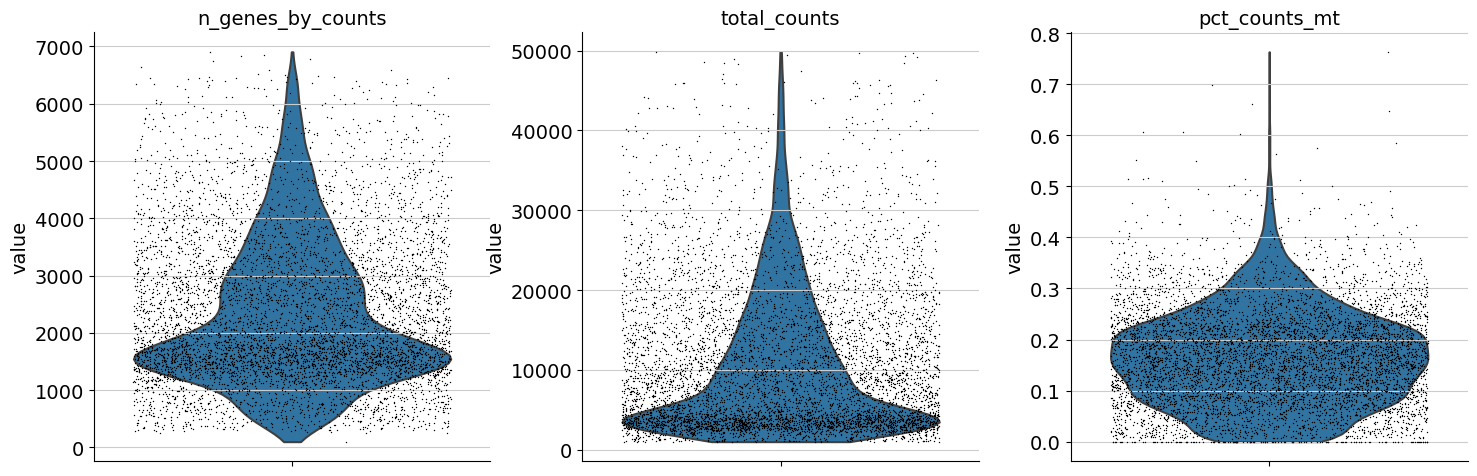

In [8]:
# Create violin plots for various QC metrics
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    save='_qc.pdf'
)

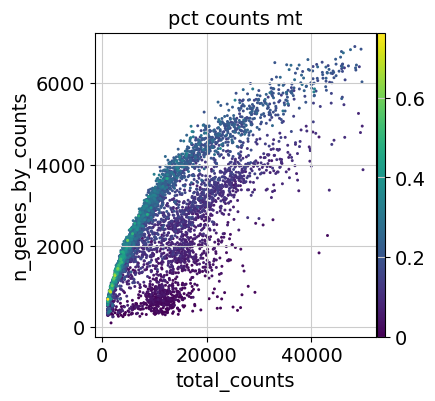

In [10]:
# Create a scatter plot of QC metrics
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Filter data to cells with between 100-2500 genes and genes with a at least 3 cells

In [11]:
# Filters data according min and max genes for cells and min cells for genes
def qc_filters(adata, min_genes=100, max_genes=2500, min_cells=3):
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_cells(adata, max_genes=2500)
    sc.pp.filter_genes(adata, min_cells=3)
    return adata

adata = qc_filters(adata)

Normalise and logarithmize count data

In [12]:
def normalise_data(adata):
    adata.layers["counts"] = adata.X.copy()
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize
    sc.pp.log1p(adata)
    return adata

adata = normalise_data(adata)

Feature selection,  select the most highly variable genes for further analysis

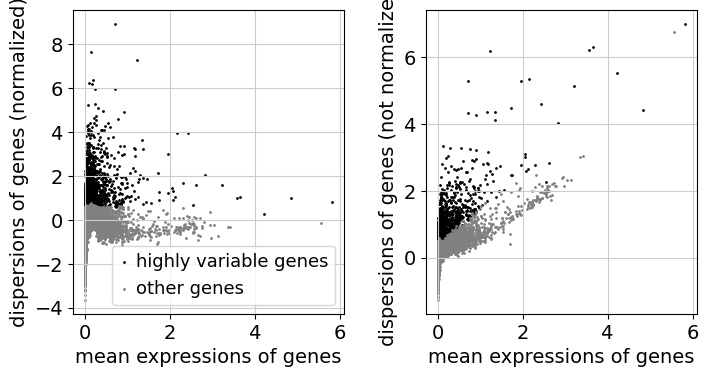

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata)

Scale data

In [14]:
sc.pp.scale(adata)

PCA

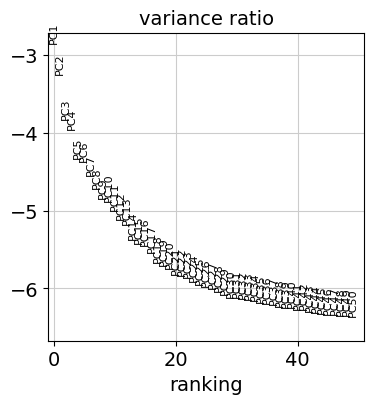

In [15]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

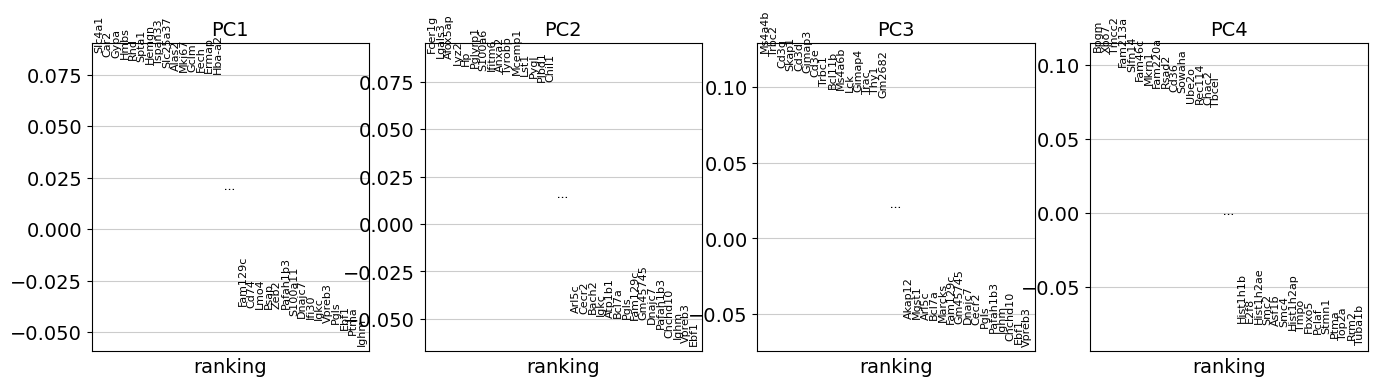

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


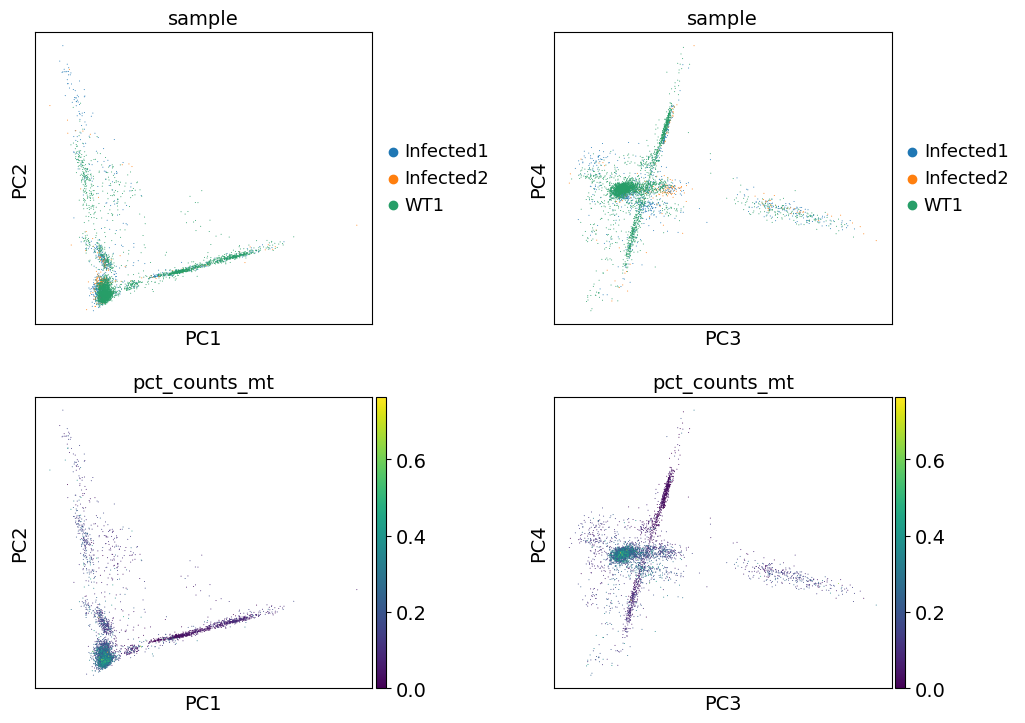

In [16]:
sc.pl.pca_loadings(adata, components = '1,2,3,4',save='.pdf')
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
    wspace=0.4,
    return_fig=True
).savefig('./figures/pca_scatter.pdf', bbox_inches='tight')

UMAP with un-integrated data

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


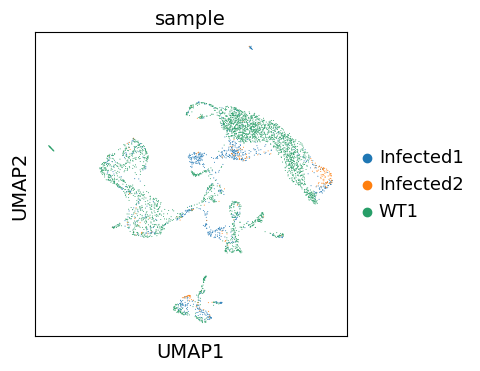

In [ ]:
# Create a copy of adata for the un-integrated UMAP
uninter_adata = adata.copy()

# Carries out a UMAP and outputs a scatter plot. 
def run_umap(adata, fig_filepath, n_pcs=None, use_rep=None):
    # Compute a nearest neighbours graph
    sc.pp.neighbors(adata, n_pcs=n_pcs, use_rep=use_rep)
    # Embed the graph with UMAP
    sc.tl.umap(adata)
    # Plot a scatter plot of the umap
    sc.pl.umap(
        adata,
        color="sample",
        size=2,
        return_fig=True
    ).savefig(fig_filepath, bbox_inches='tight')

# Run UMAP on unitegrated data
run_umap(uninter_adata,'./figures/umap.pdf', n_pcs=28)

Integration with scanorama, scanorama is used as it yielded the best integration

In [19]:
# Create a copy of adata for integration
adata_integrated = adata.copy()
# Integrate with scanorama based on sample
sc.external.pp.scanorama_integrate(adata_integrated, "sample")


[[0.         0.89054726 0.8128655 ]
 [0.         0.         0.59701493]
 [0.         0.         0.        ]]
Processing datasets Infected1 <=> Infected2
Processing datasets Infected1 <=> WT1
Processing datasets Infected2 <=> WT1


UMAP with scanorama-integrated data

/software/Anaconda3-2023.03/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


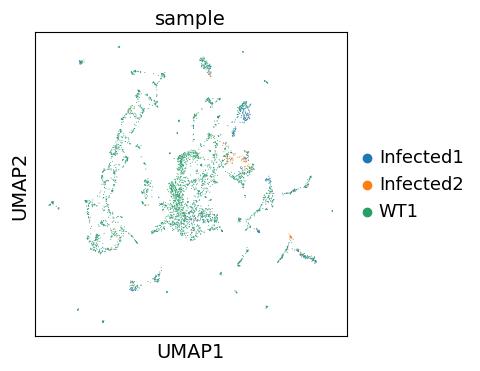

In [22]:
# Run UMAP on integrated data
run_umap(adata_integrated,'./figures/scano_umap.pdf', use_rep="X_scanorama")

Next clustering is carried, resolution of 0.1 is chosen in order to yield 14 clusters.

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


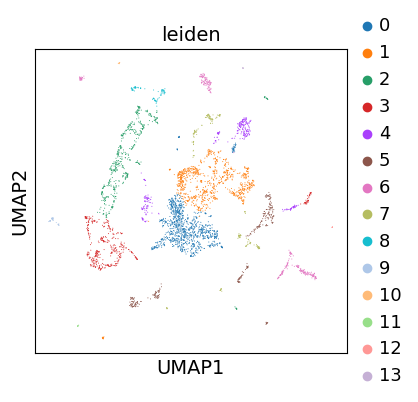

In [23]:
sc.tl.leiden(adata_integrated, resolution=0.1, n_iterations=-1) 
sc.pl.umap(adata_integrated, color=["leiden"], size=2, return_fig=True).savefig('./figures/scano_umap_clusters.pdf', bbox_inches='tight')

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.l

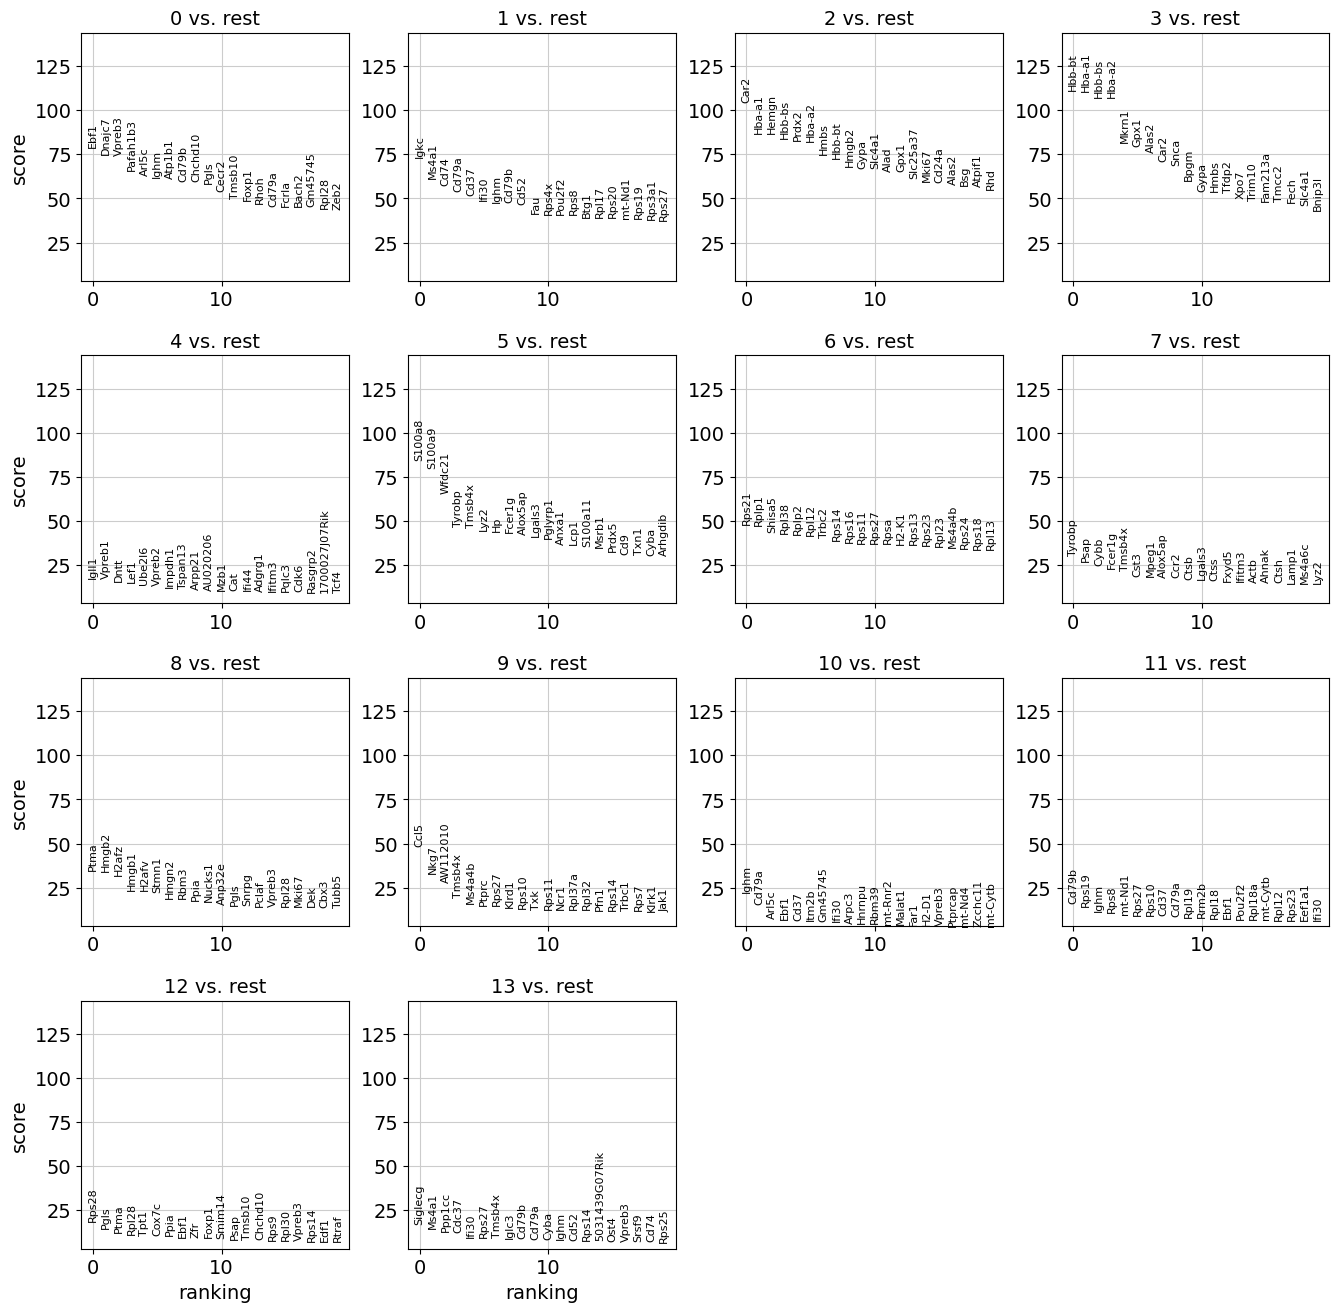

In [ ]:
# Rank gene groups to aid in annotation
sc.tl.rank_genes_groups(adata_integrated, 'leiden')
sc.pl.rank_genes_groups(adata_integrated, save = 'markers.pdf') #.savefig('./markers.pdf', bbox_inches='tight')


The 3 largest clusters are annotated manually. 

In [37]:
#adata_integrated.obs["cell_type"] = adata_integrated.obs["leiden"]
adata_integrated.obs["cell_type"] = adata_integrated.obs["leiden"].map(
    {
        "0": "0 B Cells",
        "1": "1 B Cells",
        "2": "2 Erythroid",
        "3": "3",
        "4": "4",
        "5": "5",
        "6": "6",
        "7": "7",
        "8": "8",
        "9": "9",
        "10": "10",
        "11": "11",
        "12": "12",
        "13": "13",
        "14": "14"
        
    },na_action='ignore'
)

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


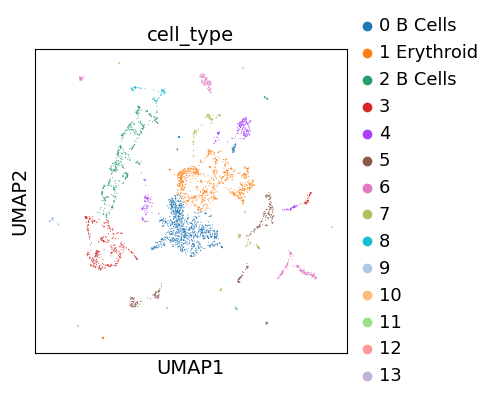

In [31]:

sc.pl.umap(adata_integrated, color=["cell_type"], size=2, return_fig=True).savefig('./figures/scano_umap_cells.pdf', bbox_inches='tight')

Differential expression

In [38]:
# Get the cluster containing Ms4a1
b_cells_adata = adata_integrated[adata_integrated.obs['cell_type'] == '1 B Cells',:]
# add sample sample type
b_cells_adata.obs['sample_type'] = b_cells_adata.obs['sample'].map({
        "WT1": "WT",
        "Infected1": "Infected",
        "Infected2": "Infected",
        
    },)

/tmp/ipykernel_2892912/668371510.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  b_cells_adata.obs['sample_type'] = b_cells_adata.obs['sample'].map({


/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


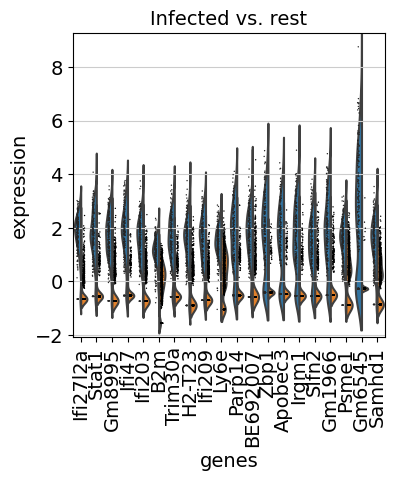

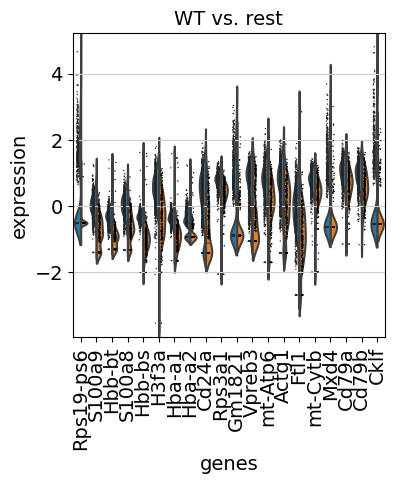

In [39]:
sc.tl.rank_genes_groups(b_cells_adata, 'sample_type')
sc.pl.rank_genes_groups_violin(b_cells_adata, save = '_VDE.pdf')

Get number of significant genes; p < 0.01 and log2fold > 0.5

In [73]:
def get_sig_genes(adata, group="WT"):
    sc.tl.rank_genes_groups(adata, 'sample_type')
    de_df = sc.get.rank_genes_groups_df(adata, group=group)
    de_df = de_df.loc[de_df['pvals'] < 0.01,:]
    de_df = de_df.loc[de_df['logfoldchanges'] < 0.5,:]
    return de_df
print(f'Number of sig genes: {len(get_sig_genes(b_cells_adata, group="WT"))}')

Number of sig genes: 558


/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


Harmony integration

In [68]:
adata_integrated_harmony = adata.copy()
sc.external.pp.harmony_integrate(adata_integrated_harmony, "sample")

2025-04-08 08:52:15,854 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x74778c381090>
Traceback (most recent call last):
  File "/software/Anaconda3-2023.03/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/software/Anaconda3-2023.03/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/software/Anaconda3-2023.03/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/software/Anaconda3-2023.03/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exceptio

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


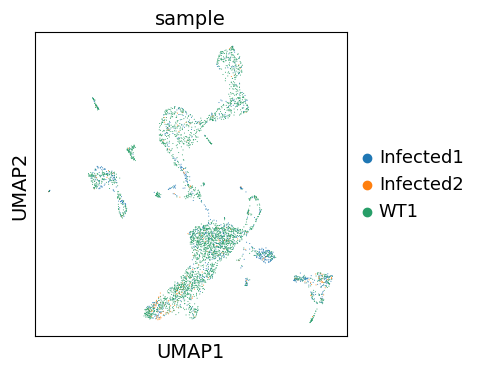

In [74]:
run_umap(adata_integrated_harmony,'./plots/harmony_i_umap.pdf', use_rep="X_pca_harmony")

Clustering

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


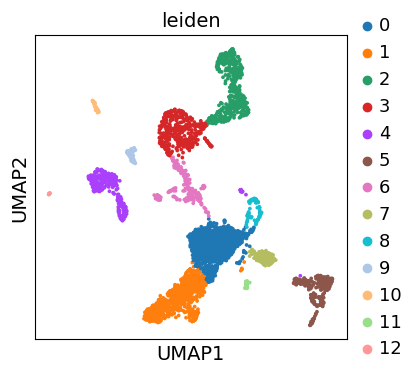

In [75]:
sc.tl.leiden(adata_integrated_harmony, resolution=0.2, n_iterations=-1) #sc.tl.leiden(adata_integrated, resolution=0.044, n_iterations=-1)
sc.pl.umap(adata_integrated_harmony, color=["leiden"], return_fig=True).savefig('./plots/harmony_i_umap_clusters.pdf', bbox_inches='tight')

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.l

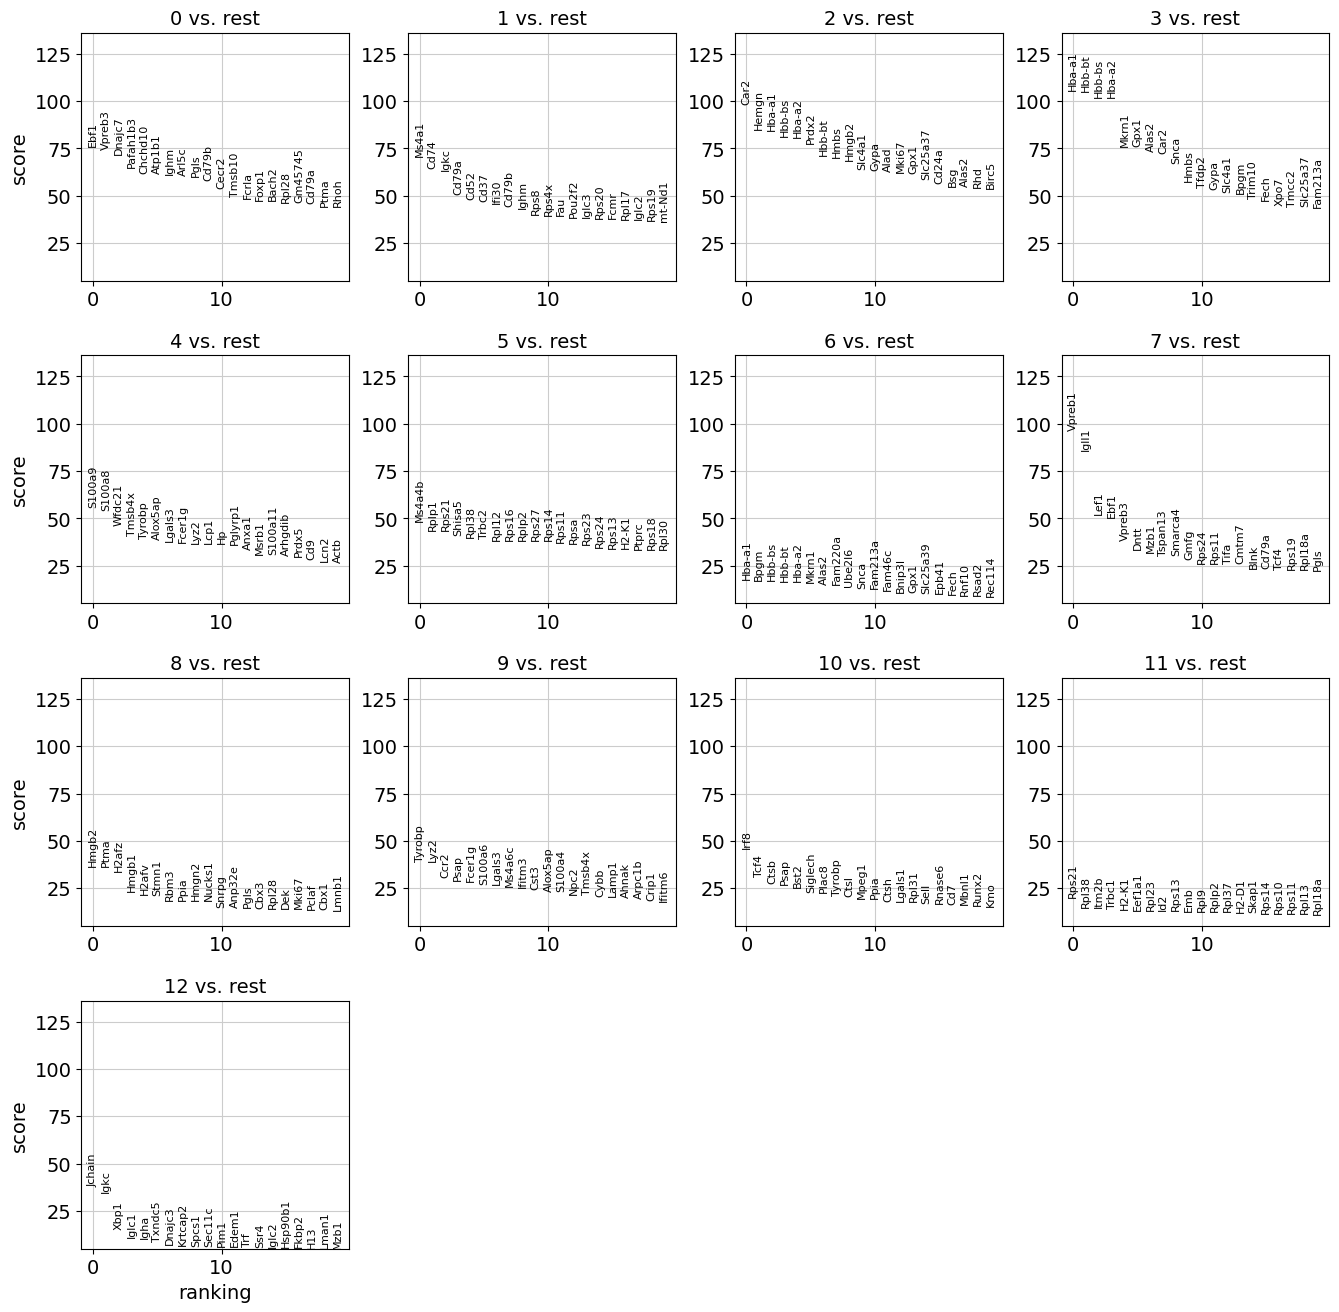

In [76]:
sc.tl.rank_genes_groups(adata_integrated_harmony, 'leiden')
sc.pl.rank_genes_groups(adata_integrated_harmony, save = '_harmony.pdf')

In [77]:
b_cells_adata_harmony = adata_integrated_harmony[adata_integrated_harmony.obs['leiden'] == '1',:]
b_cells_adata_harmony.obs['sample_type'] = b_cells_adata_harmony.obs['sample'].map({
        "WT1": "WT",
        "Infected1": "Infected",
        "Infected2": "Infected",
        
    },)

/tmp/ipykernel_2892912/3646125944.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  b_cells_adata_harmony.obs['sample_type'] = b_cells_adata_harmony.obs['sample'].map({


/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


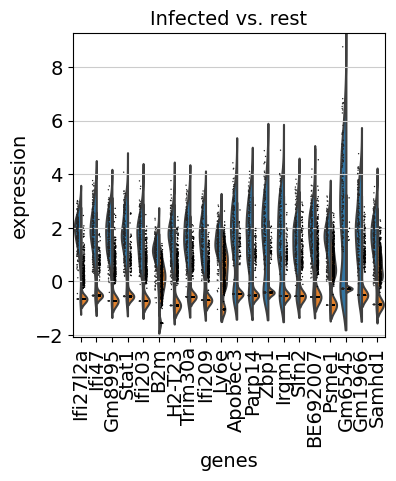

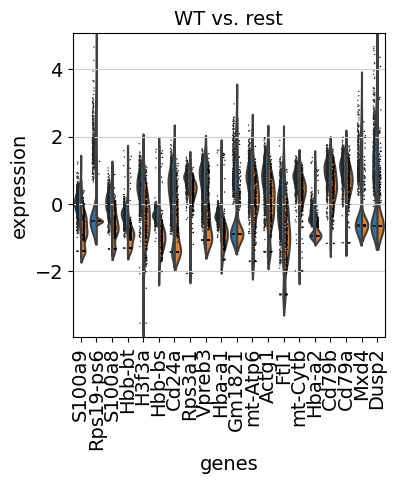

In [78]:
sc.tl.rank_genes_groups(b_cells_adata_harmony, 'sample_type')
sc.pl.rank_genes_groups_violin(b_cells_adata_harmony, save = '_harmony_VDE.pdf')

In [79]:
print(f'Number of sig genes: {len(get_sig_genes(b_cells_adata_harmony, group="WT"))}')

Number of sig genes: 494


/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


Pseudobulk

In [ ]:
#sc.get.aggregate(b_cells_adata, by=["sample", "cell_type"], func="sum", layer="counts")
def pseudobulk_samples(adata):
    genes = adata.var_names
    samples = adata.obs['sample'].unique()
    
    sample_types = adata.obs['sample_type'].unique()
    pseudobulk_df = pd.DataFrame(0, samples, genes)

    metadata = pd.DataFrame('NA', samples, columns=['sample_type'])
    

    for sample in samples:
        for sample_type in sample_types:
            if sample.startswith(sample_type):
                metadata['sample_type'][sample] = sample_type

        sample_adata = adata[adata.obs['sample']==sample]
        counts = sum(sample_adata.layers['counts'])

        for i in range(len(genes)):
            pseudobulk_df[genes[i]][sample] = counts[i]

    return pseudobulk_df, metadata

b_cells_pseudobulk, metadata = pseudobulk_samples(b_cells_adata)
metadata


,sample_type
Infected1,Infected
Infected2,Infected
WT1,WT


In [253]:
#b_cells_adata['ATCCGTCGTTGGGTAG_4'].layers['counts']
i = 0
for gene in b_cells_adata[b_cells_adata.obs['sample_type']=='WT'].layers['counts']:
    #print(len(gene))
    i += 1
    if i > 4:
        break
     #['Mrpl15']
#b_cells_adata.obs['sample_type'=='`WT']
test_genes = b_cells_adata.var_names
test_types = b_cells_adata.obs['sample_type'].unique()
test_df = pd.DataFrame(0, test_genes, test_types)
type(test_df['WT']['Mrpl15'])

numpy.int64

In [ ]:
test = b_cells_adata[b_cells_adata.obs['sample_type']=='WT']
print(type(s(sum(test.layers['counts']))))
pd.Series(sum(test.layers['counts']))

<class 'pandas.core.series.Series'>


0         58.0
1          0.0
2         48.0
3        155.0
4         46.0
         ...  
17379      0.0
17380      0.0
17381      1.0
17382      0.0
17383      0.0
Length: 17384, dtype: float32

Trajectory analysis

/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


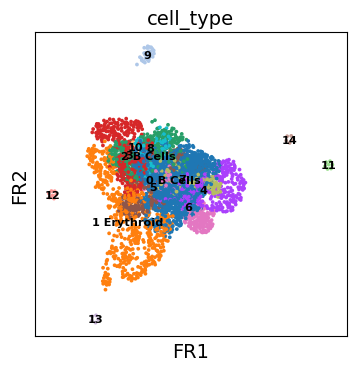

In [179]:
# use the umap to initialize the graph layout.
sc.tl.draw_graph(adata_integrated, init_pos='X_umap')
sc.pl.draw_graph(adata_integrated, color='cell_type', legend_loc='on data', legend_fontsize = 'xx-small',return_fig=True).savefig('./plots/umap_traj.pdf', bbox_inches='tight')


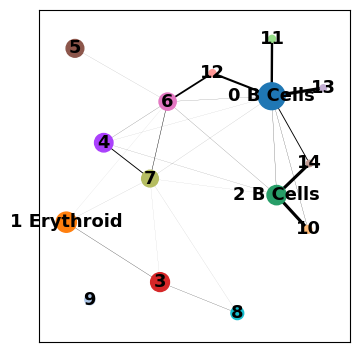

In [ ]:
sc.tl.paga(adata_integrated, groups='cell_type')
sc.pl.paga(adata_integrated, color='cell_type', edge_width_scale = 0.3,return_fig=True).savefig('./plots/paga.pdf', bbox_inches='tight')

PHATE

In [173]:
sc.external.tl.phate(adata_integrated, k=5, a=20, t=150)

/software/Anaconda3-2023.03/lib/python3.10/site-packages/phate/phate.py:186: FutureWarning: k is deprecated. Please use knn in future.
  warnings.warn("k is deprecated. Please use knn in future.", FutureWarning)
/software/Anaconda3-2023.03/lib/python3.10/site-packages/phate/phate.py:190: FutureWarning: a is deprecated. Please use decay in future.
  warnings.warn("a is deprecated. Please use decay in future.", FutureWarning)


/software/Anaconda3-2023.03/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


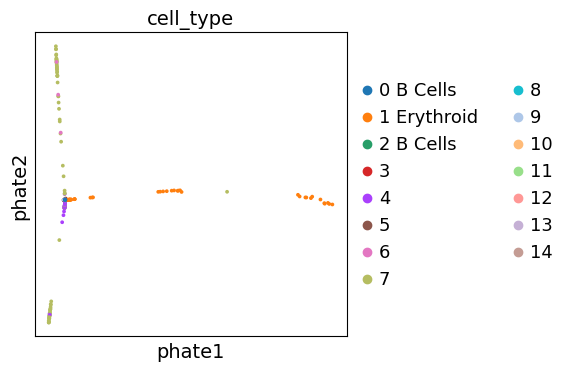

In [178]:
sc.external.pl.phate(adata_integrated,color="cell_type",color_map="tab20",return_fig=True).savefig('./plots/phate.pdf', bbox_inches='tight')